# Uncertainty Regression


The basic assumption of regression with standard loss function is homoskedasticity, ie, the variance at each measurement is a constant. In reality, it's usually not the case -- the spread of the target can vary along the domain. We call it heteroskedasticity.

In this notebook, we will study how to take heteroskedascity into consideration when doing non-parametric regression.

### Creating the dataset

In [11]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
import random
random.seed(0)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Concatenate, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)

gpu-4-culture-plate-sm  Thu Jul 25 07:03:18 2019
[0] GeForce GTX 1080 | 58'C,  46 % |  1495 /  8114 MB | azlokapa(1485M)
[1] GeForce GTX 1080 | 64'C,  46 % |  1427 /  8114 MB | azlokapa(1417M)
[2] GeForce GTX 1080 | 59'C,  46 % |  1427 /  8114 MB | azlokapa(1417M)
[3] GeForce GTX 1080 | 34'C,   0 % |  7561 /  8114 MB | thong(7551M)
[4] GeForce GTX 1080 | 57'C,  39 % |  1427 /  8114 MB | azlokapa(1417M)
[5] GeForce GTX 1080 | 63'C,  47 % |  1421 /  8114 MB | azlokapa(1411M)
[6] GeForce GTX 1080 | 55'C,  38 % |  5234 /  8114 MB | thong(3807M) azlokapa(1417M)
[7] GeForce GTX 1080 | 57'C,  35 % |  1427 /  8114 MB | azlokapa(1417M)


/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Number of data points:  2000


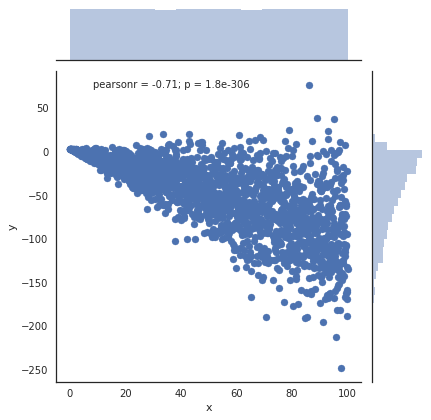

In [42]:
x = np.arange(100, step=0.05)
y = 3-2*x + np.random.normal(x, x/2)
yval = 3-2*x + np.random.normal(x, x/2)
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
sns.jointplot(x="x", y="y", data=data)

# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

$x$ is an uniform distribution and $y$ is similar to a log-norm distribution. $p(y|x)$ is a sum of a Gaussian and a linear function.

### MSE Regressor

In [3]:
inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss='mse', optimizer='adam')
model.summary()

model.fit(x_train,y_train,  epochs=100, batch_size=10, verbose=1, 
          #callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 1s 725us/step - loss: 915.1177 - val_loss: 844.8733
Epoch 2/100
2000/2000 [==============================] - 1s 392us/step - loss: 831.6422 - val_loss: 886.8654
Epoch 3/100
2000/2000 [==============================] - 1s 389us/step - loss: 837.5516 - val_loss: 828.6045
Epoch 4/100
2000/2000 [======

2000/2000 [==============================] - 1s 412us/step - loss: 829.5477 - val_loss: 831.8938
Epoch 69/100
2000/2000 [==============================] - 1s 408us/step - loss: 826.7982 - val_loss: 825.6103
Epoch 70/100
2000/2000 [==============================] - 1s 421us/step - loss: 824.2649 - val_loss: 834.4903
Epoch 71/100
2000/2000 [==============================] - 1s 428us/step - loss: 827.4417 - val_loss: 842.7246
Epoch 72/100
2000/2000 [==============================] - 1s 415us/step - loss: 827.1949 - val_loss: 842.2842
Epoch 73/100
2000/2000 [==============================] - 1s 408us/step - loss: 826.5329 - val_loss: 826.8303
Epoch 74/100
2000/2000 [==============================] - 1s 421us/step - loss: 823.6188 - val_loss: 825.7579
Epoch 75/100
2000/2000 [==============================] - 1s 418us/step - loss: 825.7447 - val_loss: 826.9578
Epoch 76/100
2000/2000 [==============================] - 1s 416us/step - loss: 828.9033 - val_loss: 834.2646
Epoch 77/100
2000/2000 

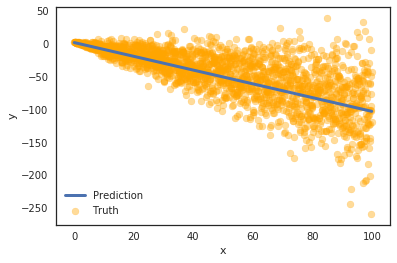

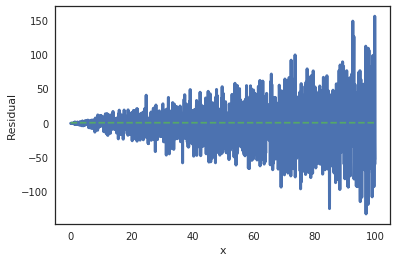

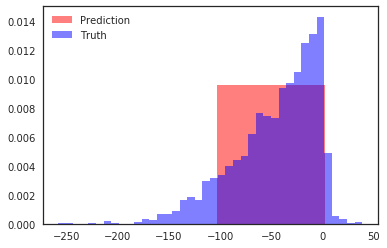

In [53]:
yhat = model.predict(x)
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(yhat,  bins=40, color='red', alpha=0.5, label='Prediction', density=True)
plt.hist(yval, color='blue', bins=40, alpha=0.5, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

As we can see from the first and second plots, a simple regression with MSE loss function is good enough for doing a fit that predicts the conditional mean $(y|x)$. However, the marginal distribution $p(y)$ itself is quite off, from the bottom plot. We also can't quantify the uncertainty of the prediction -- how to do this? 

One approach is to reparametrize the output prediction of each point into a pdf $N(\mu, \sigma)$ and maximize its likelihood given the input data. 

### Gaussian Regressor

In [17]:
def InverseSquareRootLinearUnit(args, min_value = 5e-5):
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1.+K.square(args))))

def gauss_loss(y_true, y_pred):
    mu = y_pred[:,0]
    sigma = y_pred[:,1]
    norm_x = K.tf.divide(y_true - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    return K.sum(single_NLL, axis=-1)

def sum_of_gaussians(x, mu_vec, sigma_vec):
    # x: numpy array of the bin centers
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

In [37]:
inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output_mu = Dense(1)(hidden)
output_sigma = Dense(1)(hidden)
output_sigma = Lambda(InverseSquareRootLinearUnit)(output_sigma)
output = Concatenate(axis=-1)([output_mu, output_sigma])
Gaussian_model_ordered = Model(inputs, output)
Gaussian_model_ordered.compile(loss=gauss_loss, optimizer='adam')
Gaussian_model_ordered.summary()

# x, y are unshuffled, where x increasing monotonically from 0 to 100.
Gaussian_model_ordered.fit(x, y,
            validation_data=(x,yval),
            epochs=500, batch_size=10, verbose=1, 
            callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
          )



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 1000)         2000        input_14[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 1)            1001        dense_39[0][0]                   
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 1)            1001        dense_39[0][0]                   
__________________________________________________________________________________________________
lambda_13 

Epoch 60/500
2000/2000 [==============================] - 1s 593us/step - loss: 69.1062 - val_loss: 38.0170
Epoch 61/500
2000/2000 [==============================] - 1s 628us/step - loss: 68.2201 - val_loss: 38.3148
Epoch 62/500
2000/2000 [==============================] - 1s 586us/step - loss: 65.8119 - val_loss: 38.6260


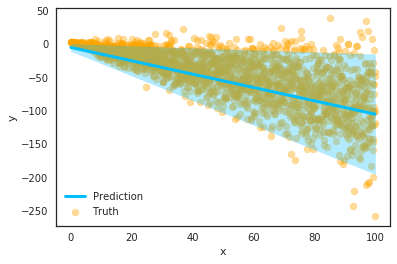

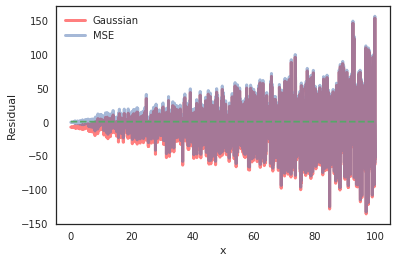

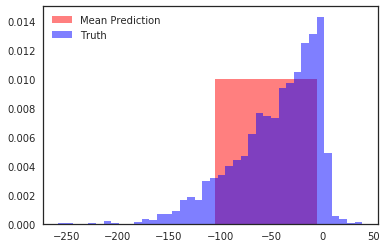

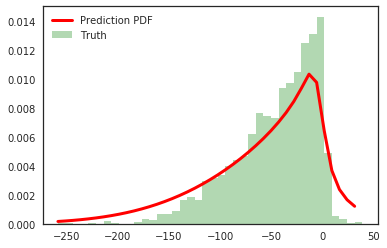

In [62]:
y_gauss = Gaussian_model_ordered.predict(x)
y_gauss_mean = y_gauss[:,0]
y_gauss_var = y_gauss[:,1]

plt.scatter(x,yval, color='orange', label='Truth', alpha=0.4)
plt.plot(x,y_gauss_mean, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, y_gauss_mean-y_gauss_var,y_gauss_mean+y_gauss_var, alpha=0.3, color='deepskyblue')


plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

plt.figure()
res_ygauss = y_gauss_mean.flatten()-yval
plt.plot(x, res_ygauss, color='red', linewidth=3, alpha=0.5, label='Gaussian')
plt.plot(x, res_y, linewidth=3, alpha=0.5, label='MSE')
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend(loc='best')
plt.show()

N_bins = 40

plt.figure()
plt.hist(y_gauss_mean,  bins=N_bins, color='red', alpha=0.5, label='Mean Prediction', density=True)
plt.hist(yval, color='blue', bins=N_bins, alpha=0.5, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
bin_content = sum_of_gaussians(z, y_gauss_mean, y_gauss_var)
plt.figure()
plt.plot(z,bin_content, linewidth=3, color='red', label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

So far so good: the Guassian model can capture the mean and sigma of the dataset and perfectly reconstruct the marginal distribution $p(y)$. (The training is unstable though: sometimes with the wrong initialization you get a huge bias -- try it yourself. The above result is obtained after rerunning the cell 15 times.) 

However, there is another huge catch: in the training above I use the unshuffled data, ie, $x$ is a monotonically increasing function. If I use the shuffled $x_{train}, y_{train}$ instead, one would expect nothing change. This is when surprise comes:

In [40]:
inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output_mu = Dense(1)(hidden)
output_sigma = Dense(1)(hidden)
output_sigma = Lambda(InverseSquareRootLinearUnit)(output_sigma)
output = Concatenate(axis=-1)([output_mu, output_sigma])
Gaussian_model = Model(inputs, output)
Gaussian_model.compile(loss=gauss_loss, optimizer='adam')
Gaussian_model.summary()

# x_train, y_train were shuffled in unison.
Gaussian_model.fit(x_train, y_train,  epochs=500, batch_size=10, verbose=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                  validation_data=(x_train, y_trainval))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 1000)         2000        input_15[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 1)            1001        dense_42[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 1)            1001        dense_42[0][0]                   
__________________________________________________________________________________________________
lambda_14 

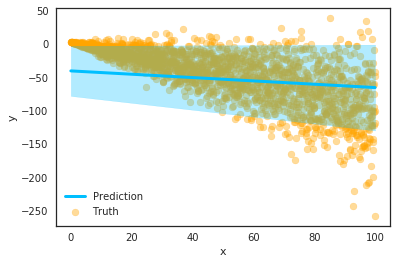

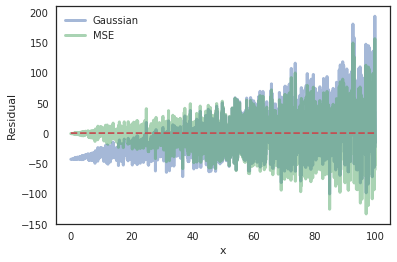

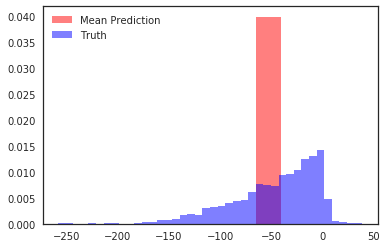

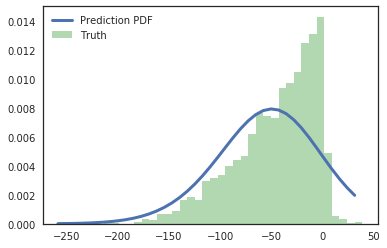

In [55]:
y_gauss = Gaussian_model.predict(x)
y_gauss_mean = y_gauss[:,0]
y_gauss_var = y_gauss[:,1]

plt.scatter(x,yval, color='orange', label='Truth', alpha=0.4)
plt.plot(x,y_gauss_mean, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, y_gauss_mean-y_gauss_var,y_gauss_mean+y_gauss_var, alpha=0.3, color='deepskyblue')


plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

plt.figure()
res_ygauss = y_gauss_mean.flatten()-yval
plt.plot(x, res_ygauss, linewidth=3, alpha=0.5, label='Gaussian')
plt.plot(x, res_y, linewidth=3, alpha=0.5, label='MSE')
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend(loc='best')
plt.show()

N_bins = 40

plt.figure()
plt.hist(y_gauss_mean,  bins=N_bins, color='red', alpha=0.5, label='Mean Prediction', density=True)
plt.hist(yval, color='blue', bins=N_bins, alpha=0.5, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
bin_content = sum_of_gaussians(z, y_gauss_mean, y_gauss_var)
plt.figure()
plt.plot(z,bin_content, linewidth=3, label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

It doesn't quite work -- even with multiple retries. 

I dig through literature a bit to see how statisticans do this. The solution seems quite simple: They use one neural net to estimate the mean and another one to estimate the residual. Let's try:

In [59]:
# For the model that estimate the mean, I reuse the MSE model above.
# Now I'm gonna build the model that estimate the variance

log_var = np.log(np.square(res_y))
log_var_train = log_var[idx]

inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output = Dense(1)(hidden)

sigma_model = Model(inputs, output)
sigma_model.compile(loss='mse', optimizer='adam')
sigma_model.summary()

sigma_model.fit(x_train, log_var_train,
            epochs=500, batch_size=10, verbose=1
          )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 1001      
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
2000/2000 [==============================] - 1s 576us/step - loss: 7.6138
Epoch 2/500
2000/2000 [==============================] - 1s 338us/step - loss: 6.9490
Epoch 3/500
2000/2000 [==============================] - 1s 346us/step - loss: 7.2029
Epoch 4/500
2000/2000 [==============================] - 1s 334us/step - loss: 6.3064
Epoch 5/500
2000/2000 [==============================] - 1s 

2000/2000 [==============================] - 1s 346us/step - loss: 5.6792
Epoch 87/500
2000/2000 [==============================] - 1s 332us/step - loss: 5.6366
Epoch 88/500
2000/2000 [==============================] - 1s 312us/step - loss: 5.7496
Epoch 89/500
2000/2000 [==============================] - 1s 317us/step - loss: 5.6992
Epoch 90/500
2000/2000 [==============================] - 1s 327us/step - loss: 5.6850
Epoch 91/500
2000/2000 [==============================] - 1s 323us/step - loss: 5.6385
Epoch 92/500
2000/2000 [==============================] - 1s 317us/step - loss: 5.9166
Epoch 93/500
2000/2000 [==============================] - 1s 321us/step - loss: 5.6695
Epoch 94/500
2000/2000 [==============================] - 1s 325us/step - loss: 5.6817
Epoch 95/500
2000/2000 [==============================] - 1s 302us/step - loss: 5.6153
Epoch 96/500
2000/2000 [==============================] - 1s 321us/step - loss: 5.6343
Epoch 97/500
2000/2000 [==============================] 

2000/2000 [==============================] - 1s 328us/step - loss: 5.6881
Epoch 180/500
2000/2000 [==============================] - 1s 312us/step - loss: 5.7252
Epoch 181/500
2000/2000 [==============================] - 1s 315us/step - loss: 5.6612
Epoch 182/500
2000/2000 [==============================] - 1s 327us/step - loss: 5.6522
Epoch 183/500
2000/2000 [==============================] - 1s 322us/step - loss: 5.6728
Epoch 184/500
2000/2000 [==============================] - 1s 318us/step - loss: 5.6316
Epoch 185/500
2000/2000 [==============================] - 1s 328us/step - loss: 5.6110
Epoch 186/500
2000/2000 [==============================] - 1s 309us/step - loss: 5.6552
Epoch 187/500
2000/2000 [==============================] - 1s 327us/step - loss: 5.6357
Epoch 188/500
2000/2000 [==============================] - 1s 323us/step - loss: 5.7383
Epoch 189/500
2000/2000 [==============================] - 1s 310us/step - loss: 5.6526
Epoch 190/500
2000/2000 [=====================

2000/2000 [==============================] - 1s 335us/step - loss: 5.6246
Epoch 273/500
2000/2000 [==============================] - 1s 334us/step - loss: 5.7523
Epoch 274/500
2000/2000 [==============================] - 1s 346us/step - loss: 5.6234
Epoch 275/500
2000/2000 [==============================] - 1s 346us/step - loss: 5.6084
Epoch 276/500
2000/2000 [==============================] - 1s 334us/step - loss: 5.6426
Epoch 277/500
2000/2000 [==============================] - 1s 344us/step - loss: 5.6206
Epoch 278/500
2000/2000 [==============================] - 1s 343us/step - loss: 5.6366
Epoch 279/500
2000/2000 [==============================] - 1s 339us/step - loss: 5.6891
Epoch 280/500
2000/2000 [==============================] - 1s 339us/step - loss: 5.6056
Epoch 281/500
2000/2000 [==============================] - 1s 337us/step - loss: 5.6114
Epoch 282/500
2000/2000 [==============================] - 1s 351us/step - loss: 5.6264
Epoch 283/500
2000/2000 [=====================

2000/2000 [==============================] - 1s 345us/step - loss: 5.6369
Epoch 366/500
2000/2000 [==============================] - 1s 333us/step - loss: 5.6262
Epoch 367/500
2000/2000 [==============================] - 1s 347us/step - loss: 5.6222
Epoch 368/500
2000/2000 [==============================] - 1s 339us/step - loss: 5.5820
Epoch 369/500
2000/2000 [==============================] - 1s 360us/step - loss: 5.6085
Epoch 370/500
2000/2000 [==============================] - 1s 342us/step - loss: 5.6326
Epoch 371/500
2000/2000 [==============================] - 1s 340us/step - loss: 5.6351
Epoch 372/500
2000/2000 [==============================] - 1s 351us/step - loss: 5.5960
Epoch 373/500
2000/2000 [==============================] - 1s 344us/step - loss: 5.6355
Epoch 374/500
2000/2000 [==============================] - 1s 336us/step - loss: 5.6080
Epoch 375/500
2000/2000 [==============================] - 1s 351us/step - loss: 5.7212
Epoch 376/500
2000/2000 [=====================

2000/2000 [==============================] - 1s 367us/step - loss: 5.6422
Epoch 459/500
2000/2000 [==============================] - 1s 387us/step - loss: 5.6582
Epoch 460/500
2000/2000 [==============================] - 1s 358us/step - loss: 5.7137
Epoch 461/500
2000/2000 [==============================] - 1s 351us/step - loss: 5.6264
Epoch 462/500
2000/2000 [==============================] - 1s 370us/step - loss: 5.7118
Epoch 463/500
2000/2000 [==============================] - 1s 349us/step - loss: 5.6385
Epoch 464/500
2000/2000 [==============================] - 1s 379us/step - loss: 5.6143
Epoch 465/500
2000/2000 [==============================] - 1s 393us/step - loss: 5.6170
Epoch 466/500
2000/2000 [==============================] - 1s 383us/step - loss: 5.6595
Epoch 467/500
2000/2000 [==============================] - 1s 369us/step - loss: 5.7121
Epoch 468/500
2000/2000 [==============================] - 1s 354us/step - loss: 5.6273
Epoch 469/500
2000/2000 [=====================

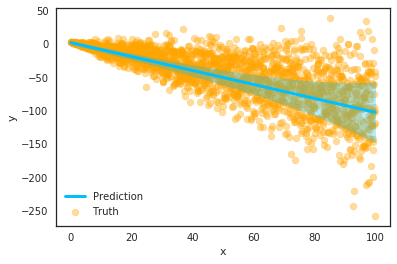

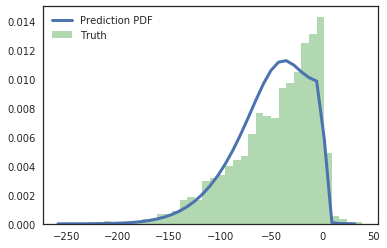

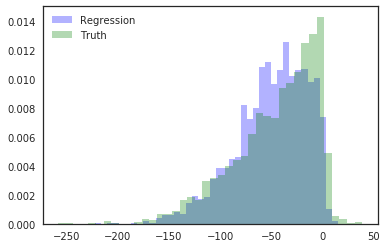

In [60]:
log_var_pred = sigma_model.predict(x)
std_pred = np.sqrt(np.exp(log_var_pred)).flatten()
yhat = yhat.flatten()
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.4)
plt.plot(x, yhat, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, yhat-std_pred, yhat+std_pred, alpha=0.3, color='deepskyblue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

N_bins = 40

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
bin_content = sum_of_gaussians(z, yhat, std_pred)
plt.figure()
plt.plot(z,bin_content, linewidth=3, label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

# Sample from predict PDF to get a new dataset
yregressed = yhat + np.random.normal(0, std_pred)
plt.figure()
plt.hist(yregressed, color='blue', bins=N_bins, alpha=0.3, label='Regression', density=True)
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()


It's not perfect, but much better!

### Takeaway messages
- MSE is good as a deterministic fit -- but to reconstruct the full marginal distribution, you need to go further.
- Don't worry about overfitting if the training data sufficiently covers the whole phase space. "Too many parameters will overfit" is a myth in deep neural network -- as long as you use minibatch it's a regularization itself.
- However, more parameters might make it easier to converge to the wrong local minima, ie, less stable. To be further verified if it's true.
- Parametrize the output to estimate the PDF only works under certain situations.
- Traditional method using 2 separated networks to estimate the mean and sigma seems to be the most reliable. One can sample from these distributions to get a regressed dataset that closely resemble the target data.